In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import itertools

import matplotlib.pyplot as plt
import mplfinance as mplf
import numpy as np
import pandas as pd

import c
import d
import simulation
import u

# Run Simulations

In [3]:
%%time

stddev = 0.5
max_holding_period = 100
start_price = 100

forecasts = np.arange(70, 130, 2)
half_life = np.arange(5, 95, 3)

results = []
for f, hl in itertools.product(forecasts, half_life):
    rho = simulation.half_life_to_rho(hl)

    r = simulation.simulate_price_target_stop_loss_mesh(
        n_samples_per_point=1000,
        target=0.05,
        price_targets=[2],
        stop_losses=[1],
        side=c.Dir.S,
        price_data_args={
            "theta": 0,
            "start_price": 100,
            "stddev": stddev,
            "use_exp": False,
            "n_samples": max_holding_period,
            "target_value": f,
            "rho": rho,
        },
    )
    r["forecast"] = f
    r["half_life"] = hl
    r["sharpe"] = r["profit_mean"] / r["profit_stddev"]

    results.append(r)
results = pd.concat(results)

CPU times: total: 1h 50min 57s
Wall time: 1h 54min 7s


# Plot Sharpe Ratio for various Forecasts/Half-Life

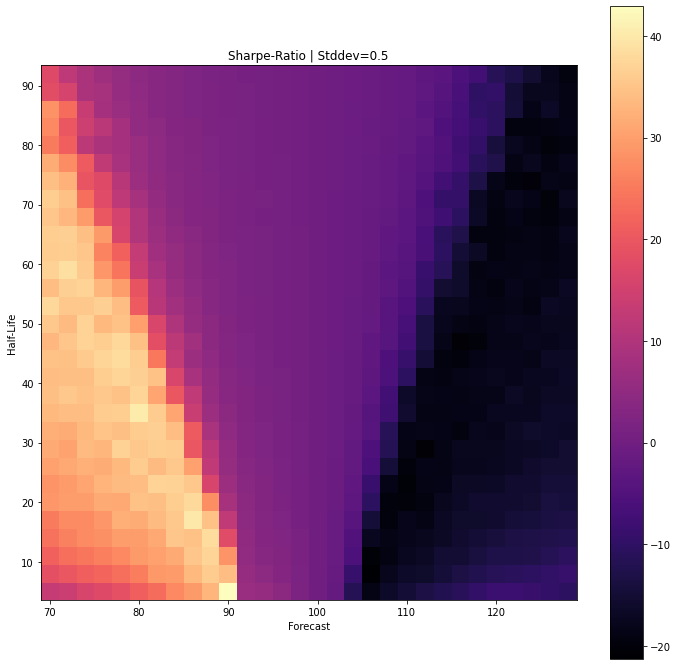

In [4]:
plt.rcParams["figure.figsize"] = (12, 12)

shape = (len(forecasts), len(half_life))
plt.pcolormesh(
    results["forecast"].values.reshape(shape),
    results["half_life"].values.reshape(shape),
    results["sharpe"].values.reshape(shape),
    cmap="magma",
)
plt.xlabel("Forecast")
plt.ylabel("Half-Life")
plt.title(f"Sharpe-Ratio | Stddev={stddev}")
plt.colorbar()
plt.gca().set_box_aspect(1)

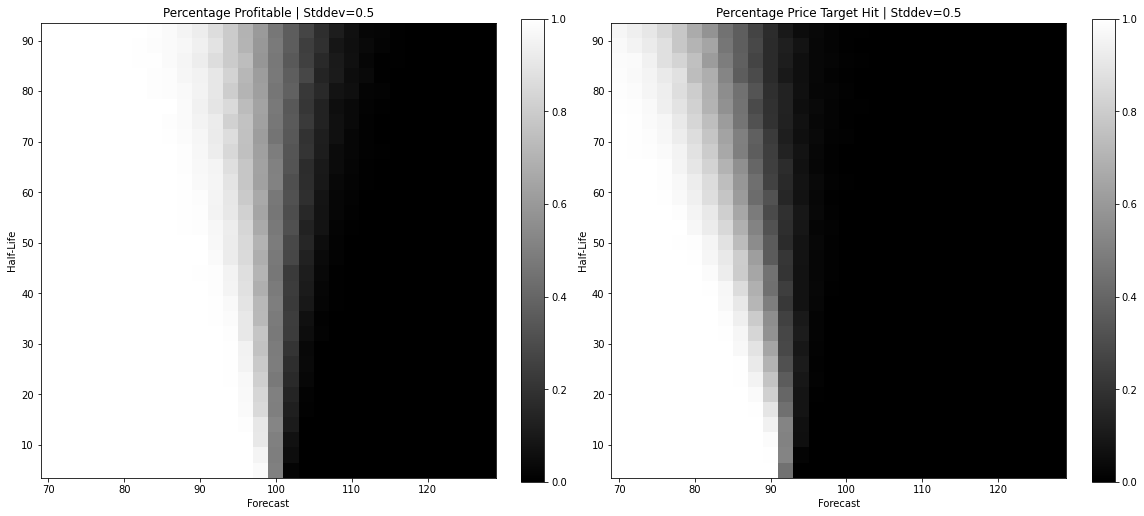

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 24))

profit_percentage = results["profit"].apply(lambda x: sum(x >= 0) / len(x))
cb0 = ax[0].pcolormesh(
    results["forecast"].values.reshape(shape),
    results["half_life"].values.reshape(shape),
    profit_percentage.values.reshape(shape),
    cmap="gray",
)
ax[0].set_xlabel("Forecast")
ax[0].set_ylabel("Half-Life")
ax[0].set_title(f"Percentage Profitable | Stddev={stddev}")
ax[0].set_box_aspect(1)
fig.colorbar(cb0, ax=ax[0], fraction=0.046)

pt_percentage = results["profit"].apply(lambda x: sum(x >= 10) / len(x))
cb1 = ax[1].pcolormesh(
    results["forecast"].values.reshape(shape),
    results["half_life"].values.reshape(shape),
    pt_percentage.values.reshape(shape),
    cmap="gray",
)
ax[1].set_xlabel("Forecast")
ax[1].set_ylabel("Half-Life")
ax[1].set_title(f"Percentage Price Target Hit | Stddev={stddev}")
ax[1].set_box_aspect(1)
fig.colorbar(cb1, ax=ax[1], fraction=0.046)

fig.set_tight_layout(True)